In [29]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

In [30]:
df = pd.read_csv('full_onion_data.csv')

In [31]:
df.columns
df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
       'MIN', 'MAX'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
df = df.set_index("DATE")
df['MODAL'] = df['MODAL'].apply(lambda x: int(x))
Interpolated_df = df.resample('1D').interpolate(mehod= "linear")

In [32]:
# grouping into years
groups = Interpolated_df.groupby(pd.Grouper(freq='A'))
years= {}
for name, group in groups:
    years[name.year] = group

In [33]:
req_years1 = [2010, 2012, 2014, 2016, 2018,2020]
# req_years1 = [2018,2019,2020] # test_error= 5653 244 days
# req_years1 = [2016,2017,2018,2019,2020] # test_error=2792 244 days
# req_years1 = [2017,2018,2019,2020]
req_years2 = [2011,2013, 2015, 2017,2019]
# req_years2 = [2015, 2017,2019]

In [44]:
def make_model(req_years, years_data, rolling_days):
    
    #data prepeocessing
    dfs = [years_data[name] for name in req_years]
    data = pd.concat(dfs, axis= 0)
    new_index = pd.date_range(datetime(2010,1,1), periods=data.shape[0]).tolist()
    data = pd.DataFrame(data = data['MODAL'].values, index = new_index)
    data = data.rolling(rolling_days).mean()
    data = data.dropna()
    data = data.reset_index()
    data.columns = ['ds','y']
    
    #test_train_split
    train_data = data[:len(data['y']) - len(years_data[2020])]
    test_data = data[len(data['y']) - len(years_data[2020]):]
    temp_data = data.set_index('ds')
    
    #model
    model = Prophet()
    model.fit(train_data)
    
    #predictions
    future = model.make_future_dataframe(periods= len(years_data[2020]))
    future.tail()
    forecast = model.predict(future)
    #model plots
    fig = model.plot(forecast)

#     fig2 = model.plot_components(forecast)
    
    # custom train, test, prediction plots
    forecast = forecast.set_index('ds')
    train_data_len = len(train_data)
    fig, axes = plt.subplots(figsize= (12,7))
    sns.lineplot(data= temp_data, ax=  axes)
    sns.lineplot(data= forecast['yhat'][train_data_len:])
    sns.lineplot(data= forecast['yhat'][:train_data_len])
    
    #train, test error
    train_data_len = train_data.shape[0]
    train_rms = sqrt(mean_squared_error(train_data['y'], forecast['yhat'][:train_data_len]))
    print("ROOT mean squared error on training data= ",train_rms)
    test_data_len = len(forecast['yhat']) - len(train_data['y'])
    test_rms = sqrt(mean_squared_error(test_data['y'][:test_data_len], forecast['yhat'][train_data_len:]))
    print("ROOT mean squared error on testing data= ",test_rms)

In [51]:
def make_diff_add_model(req_years, years_data):
    data1 = []
    data2 = []
    for year in req_years:
        this_year = years[year].values
        next_year = years[year+1].values
        for i in range(365):
            data1.append((this_year[i] + next_year[i])/2)
            data2.append((this_year[i] - next_year[i])/2)
    
    #data preprocessing
    new_index1 = pd.date_range(start= '2010-1-1', periods= len(data1)).to_list()
    df1 = pd.DataFrame(data= data1, index= new_index1)
    df2 = pd.DataFrame(data= data2, index= new_index1)
    df1 = df1.reset_index()
    df2 = df2.reset_index()
    df1.columns = ['ds', 'y']
    df2.columns = ['ds', 'y']
    temp_data1= df1.set_index('ds')
    train_data1 = df1[:len(df1)-364]
    test_data1 = df1[len(df1)-364 :]
    
    #model and prediction
    model1  = Prophet()
    model1.fit(train_data1)
    future1 = model1.make_future_dataframe(periods= 21)
    forecast1 = model1.predict(future1)
    #model plot
    fig11 = model1.plot(forecast1) 
    train_data2 = df2[:len(df2)-364]
    test_data2 = df2[len(df2)-364:]
    model2  = Prophet()
    model2.fit(train_data2)
    future2 = model2.make_future_dataframe(periods= 21)
    forecast2 = model2.predict(future2)
    #model plot
    fig21 = model2.plot(forecast2) 
    
    #ploting
    forecast1 = forecast1.set_index('ds')
    forecast2 = forecast2.set_index('ds')
    y_hat2 = forecast1['yhat'] + forecast2['yhat']
    rms = sqrt(mean_squared_error(y_hat2[len(train_data1):], years[2018].values[:21]))
    print("ROOT mean squared error of test data= ", rms)
    fig, axes = plt.subplots(figsize= (12,7))
    sns.lineplot(data= years[2018][:21], ax= axes)
    sns.lineplot(data= y_hat2[len(train_data1):], color= 'red')


## EVEN YEARS
- the data became discontinous as we attached alternate years data
- to make it continous so that the model doenot not get effected largely due to discontinuity, rolling is added(smoothening).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



ROOT mean squared error on training data=  377.6073812978751
ROOT mean squared error on testing data=  786.7839318040369


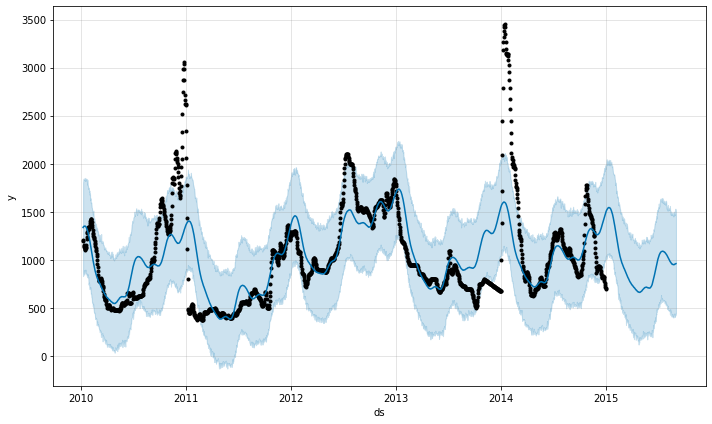

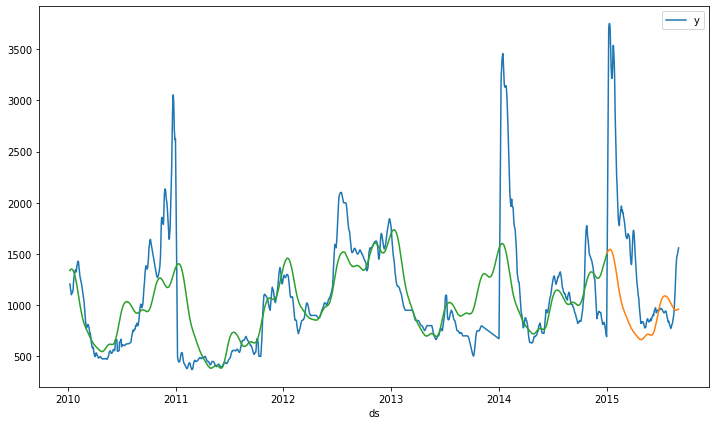

In [49]:
make_model(req_years1, years, 7)

## ODD YEARS
- the data became discontinous as we attached alternate years data
- to make it continous so that the model doenot not get effected largely due to discontinuity, rolling is added(smoothening).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



ROOT mean squared error on training data=  525.7374959760502
ROOT mean squared error on testing data=  859.1847235103972


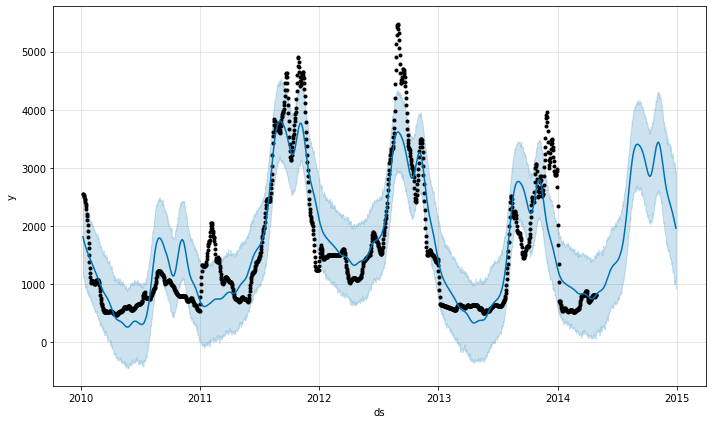

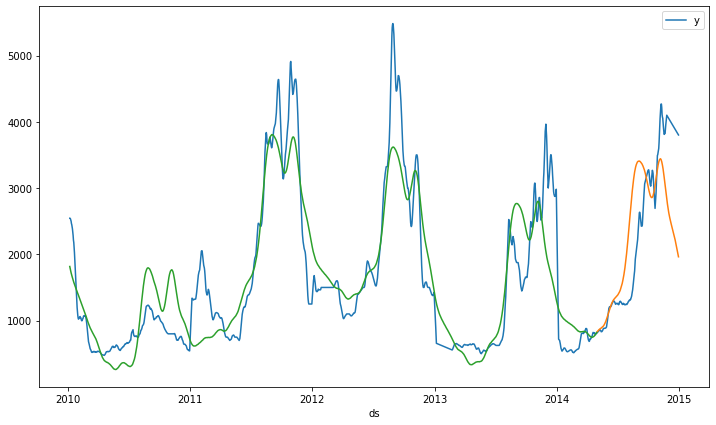

In [46]:
make_model(req_years2, years,7)

## with truncated data

- thought if decreasing few years data would make the model better as I assumed Prophet is over fitting with availability of more data, but it degraded the model.(so my assumption was wrong).
- even the predicted trend is wrong.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



ROOT mean squared error on training data=  287.74174642254
ROOT mean squared error on testing data=  3017.953796983791


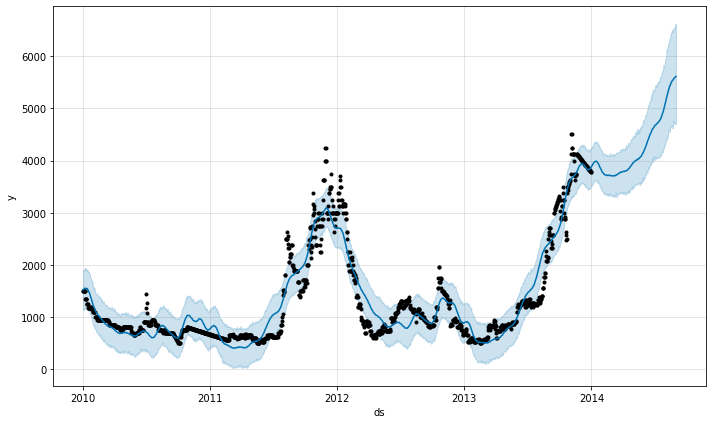

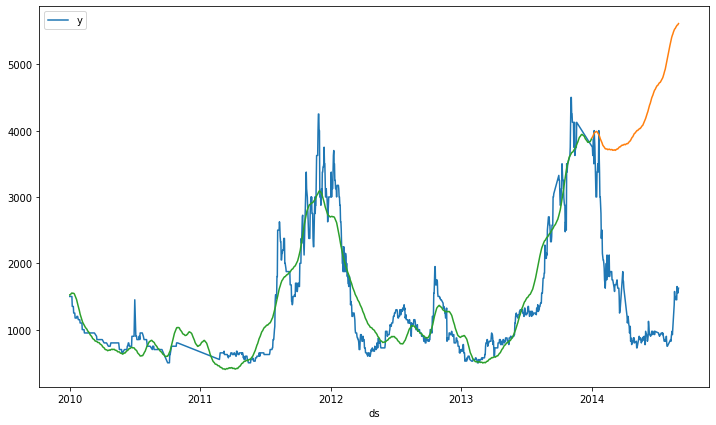

In [47]:
make_model([2016,2017,2018,2019,2020], years,1)

### Full data model
- a good prediction of trend is appeared though the peaks are not accurately predicted.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



ROOT mean squared error on training data=  657.8449873303166
ROOT mean squared error on testing data=  873.3326520812636


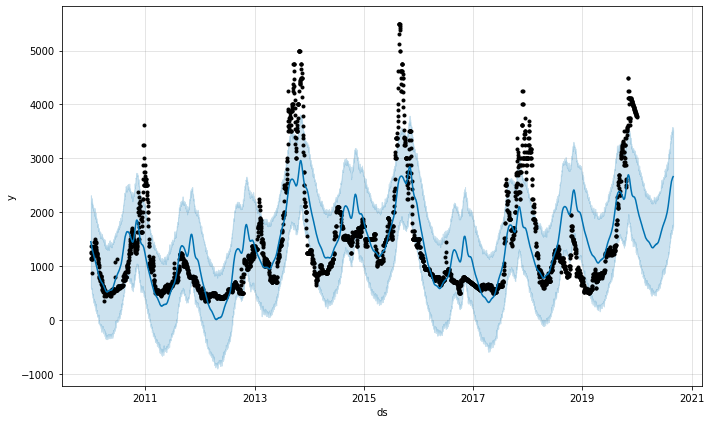

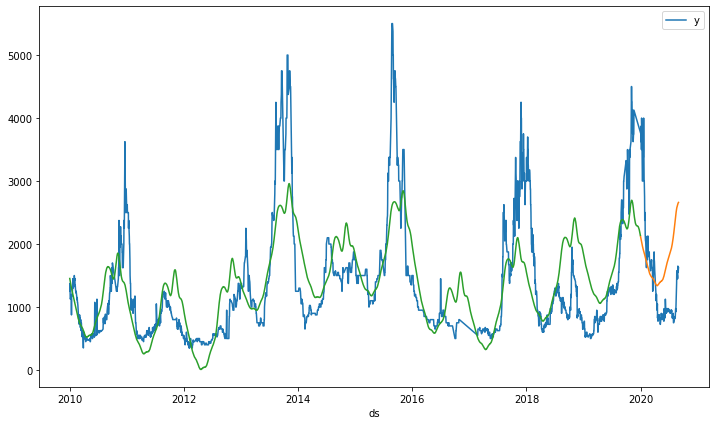

In [48]:
make_model([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020],years,1)

### Combining two years data with addition and subtraction
- This is done  as we saw seasonality of 2 years(approx) but Prophet model want a seasonality of 1 year.
- But the results didot seem to be good as seasonality is not exact 2 years(there is some shift and abnormalites in few years which is out of pattern).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROOT mean squared error of test data=  2433.571992906064


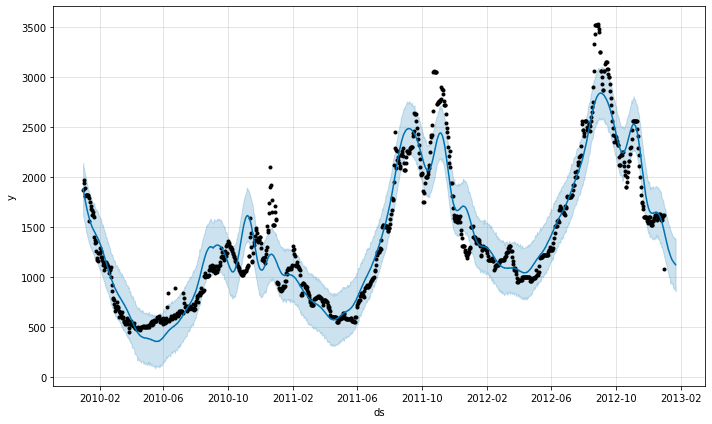

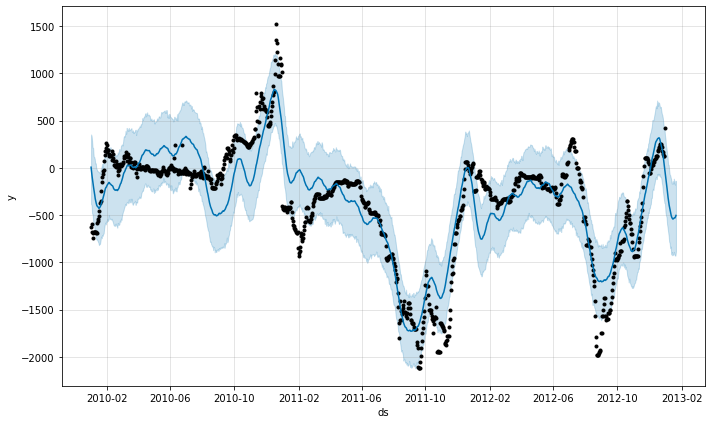

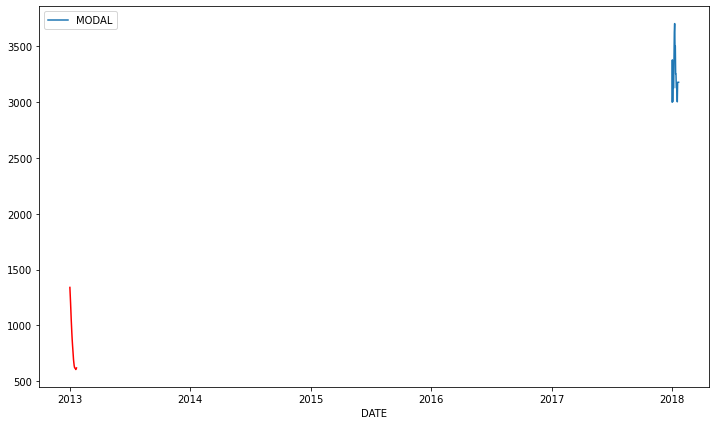

In [52]:
make_diff_add_model([2010,2012,2014,2016], years)

- Red value is prediction of test data while blue is the real value of testdata